In [1]:
from fastai2 import *
from fastai2.vision.all import *
from fastai2.callback.fp16 import *

import pretrainedmodels

from timm import create_model

import albumentations

In [2]:
device = torch.device('cuda:0')

In [3]:
df = pd.read_csv('../input/prostate-cancer-grade-assessment/train_after_reduction .csv')

In [4]:
opt_func = partial(ranger, mom=0.9, sqr_mom=0.99, eps=1e-6, beta=0)
act_fn   = 'Mish'

In [5]:
def get_dls(bs, resize, presize=1200):
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_x = ColReader('image_id',
                   pref=Path('../input/train_images_16x800x800'),suff='.png'),
                   get_y=ColReader('isup_grade'),
                   splitter=RandomSplitter(valid_pct=0.2, seed=42),
                   item_tfms=RandomResizedCrop(presize),
                   batch_tfms=[*aug_transforms(size=resize, 
                                               flip_vert=True, 
                                               max_warp=0.0, 
                                               max_rotate=0.0),
                                               Normalize.from_stats(*imagenet_stats)]) # Normalization
    
    return dblock.dataloaders(df, bs=bs, workers = 8)

In [6]:
dls = get_dls(64, 224)

/home/orangel/miniconda3/envs/torch/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


In [7]:
len(dls.train),len(dls.valid)

(131, 33)

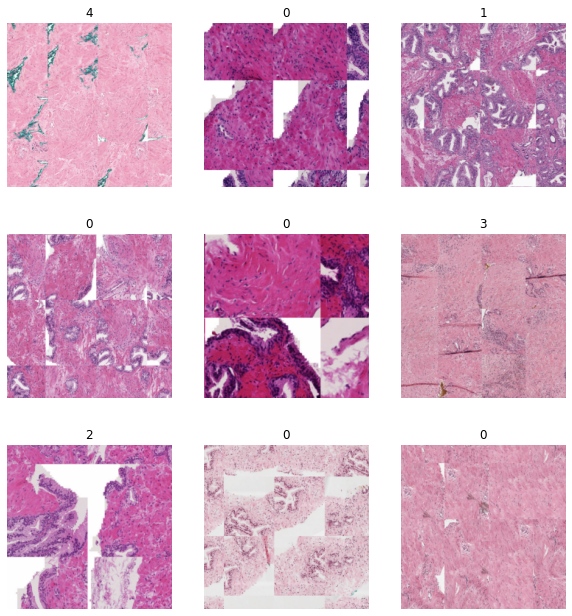

In [8]:
dls.show_batch(max_n=9, figsize=(10,11))

In [9]:
learn = cnn_learner(dls, 
                resnet101,
                splitter=default_split,
                opt_func  = opt_func,
                act_cls   = act_fn,
                metrics   = [accuracy, error_rate, CohenKappa(weights='quadratic')],
                loss_func = LabelSmoothingCrossEntropy()).to_fp16()

# --------- 64x224x244 Stage------

In [10]:
learn.fine_tune(1, 3e-3)

epoch,train_loss,valid_loss,accuracy,error_rate,cohen_kappa_score,time
0,2.473879,1.861837,0.367269,0.632731,0.454664,01:20


epoch,train_loss,valid_loss,accuracy,error_rate,cohen_kappa_score,time
0,2.059103,1.654729,0.400095,0.599905,0.519468,01:09


SuggestedLRs(lr_min=0.0002511886414140463, lr_steep=1.5848931980144698e-06)

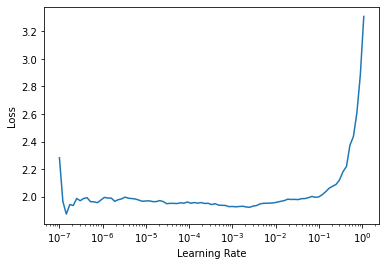

In [17]:
learn.lr_find()

In [18]:
learn.fine_tune(16)

epoch,train_loss,valid_loss,accuracy,error_rate,cohen_kappa_score,time
0,1.985246,1.693963,0.385347,0.614653,0.476498,01:08


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


epoch,train_loss,valid_loss,accuracy,error_rate,cohen_kappa_score,time
0,1.867835,1.577178,0.414843,0.585157,0.528528,01:10
1,1.820478,1.565139,0.422455,0.577545,0.537421,01:10
2,1.763532,1.531207,0.433397,0.566603,0.538189,01:11
3,1.693891,1.541898,0.439106,0.560894,0.533174,01:10
4,1.646296,1.489165,0.450999,0.549001,0.559249,01:11
5,1.608024,1.487098,0.450523,0.549477,0.567317,01:11
6,1.568301,1.473184,0.444339,0.555661,0.553569,01:10
7,1.544559,1.452450,0.463368,0.536632,0.578268,01:11
8,1.510929,1.453513,0.456232,0.543768,0.575212,01:10
9,1.511414,1.436499,0.470504,0.529496,0.579913,01:10


In [19]:
fold =1
fname = "1_224x224_july21"
learn.save("1_224x224_july21_model")
torch.save(learn.model.state_dict(), f'./trained_models/{fold}_{fname}_dic.pth')

In [20]:
interp = ClassificationInterpretation.from_learner(learn)

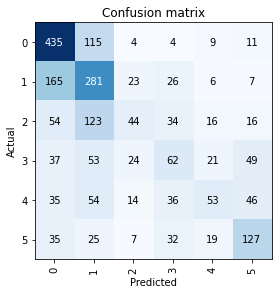

In [21]:
interp.plot_confusion_matrix()

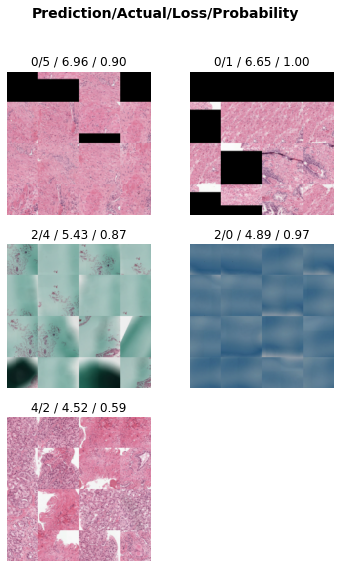

In [22]:
interp.plot_top_losses(15, nrows=3)

In [24]:
dls_256 = get_dls(32, 256)

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


In [25]:
learn.dls = dls_256

In [26]:
learn.fine_tune(16)

epoch,train_loss,valid_loss,accuracy,error_rate,cohen_kappa_score,time
0,1.506707,1.763998,0.461941,0.538059,0.582986,01:07


epoch,train_loss,valid_loss,accuracy,error_rate,cohen_kappa_score,time
0,1.456650,1.448858,0.478592,0.521408,0.608610,01:16
1,1.452357,1.410735,0.482873,0.517127,0.609623,01:18
2,1.450643,1.422040,0.486679,0.513321,0.619235,01:16
3,1.438728,1.462655,0.491437,0.508563,0.613721,01:16
4,1.443137,1.557078,0.476213,0.523787,0.610576,01:16
5,1.422146,1.419042,0.490961,0.509039,0.614024,01:16
6,1.418637,1.389354,0.503330,0.496670,0.639261,01:16
7,1.389583,1.386002,0.504757,0.495243,0.642745,01:16
8,1.362641,1.381520,0.501427,0.498573,0.647112,01:15
9,1.366579,1.377282,0.515699,0.484301,0.644110,01:15


In [27]:
interp = ClassificationInterpretation.from_learner(learn)

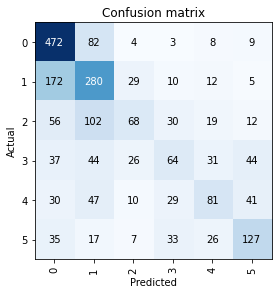

In [28]:
interp.plot_confusion_matrix()

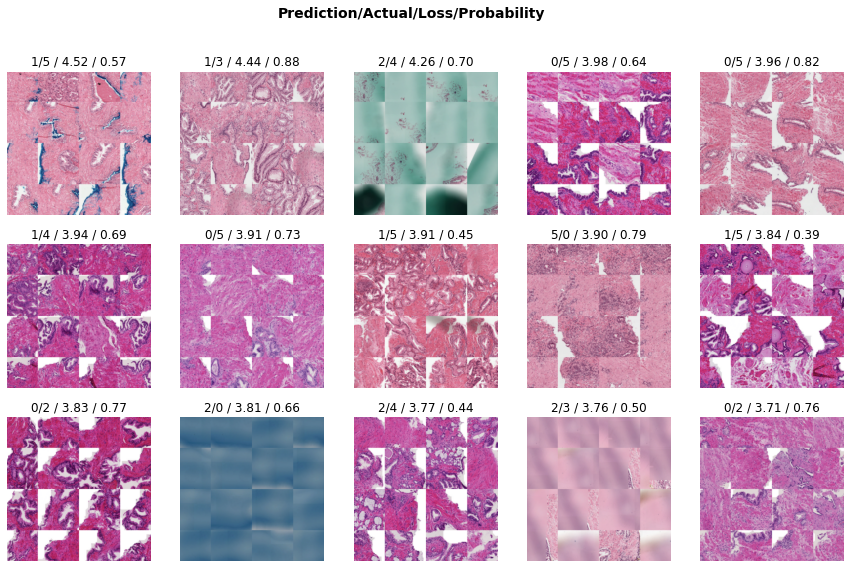

In [29]:
interp.plot_top_losses(15, nrows=3)